# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
import torch
print(torch.__version__)

2.0.1+cpu


In [ ]:
!pip install torch==1.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 824.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 55.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 1.13.1 which is incompatible.
torchvision 0.18.0+cu121 requires torch==2.3.0, but you have to

In [ ]:
!pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 980.7 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none

In [2]:
%cd /content/drive/MyDrive/ssd.pruning.pytorch
!ls

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/ssd.pruning.pytorch'
C:\Users\LENOVO\Downloads\ssd.pruning.pytorch-20240605T103800Z-001\ssd.pruning.pytorch


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
# import os
# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
import models.SSD_vggres
from models.SSD_vggres import build_ssd
from data import *

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [2]:
cfg = voc
# net = build_ssd('test', cfg, 300, 21, base='vgg', max_per_image = 200)    # initialize SSD
# net.load_state_dict(torch.load('prunes/vggSSD_finetuned_71.73.pth', map_location=torch.device('cpu')))
net = torch.load('prunes/vggSSD_finetuned_71.73.pth', map_location=torch.device('cpu'))
# net.load_weights('weights/ssd300_mAP_77.43_v2.pth')
# net
# net = torch.jit.load('weights/ssd300_77.43_prunned_optimized.torchscript.ptl', map_location=torch.device('cpu'))
net.eval()
# net = torch.jit.load('weights/ssd300_1.torchscript.ptl')

SSD_VGG(
  (L2Norm): L2Norm()
  (extras): ModuleList(
    (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  )
  (loc): ModuleList(
    (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4-5): 2 x Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conf):

In [22]:
cfg = voc
net = build_ssd('test', cfg, 300, 21, base='vgg', max_per_image = 200)    # initialize SSD
state_dict = torch.load('weights/ssd300_mAP_77.43_v2.pth', map_location=torch.device('cpu'))
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    head = k[:7] # head = k[:4]
    if head == 'module.': # head == 'vgg.', module. is due to DataParellel
        name = k[7:]  # name = 'base.' + k[4:]
    else:
        name = k
    new_state_dict[name] = v
net.load_state_dict(new_state_dict)
net.eval()

C:\Users\LENOVO\Downloads\ssd.pruning.pytorch-20240605T103800Z-001\ssd.pruning.pytorch\models\SSD_vggres.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)
C:\Users\LENOVO\Downloads\ssd.pruning.pytorch-20240605T103800Z-001\ssd.pruning.pytorch\layers\modules\l2norm.py:18: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.weight,self.gamma)


SSD_VGG(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [ ]:
net = torch.jit.load('weights/ssd300_prunned_optimized.torchscript.ptl')
net

RecursiveScriptModule(original_name=SSD_VGG)

In [23]:
from torch.utils.mobile_optimizer import optimize_for_mobile
from torch.ao.quantization.quantize_jit import fuse_conv_bn_jit

dummy_input = torch.rand(1, 3, 300, 300)  # Kích thước đầu vào 300x300 và 3 kênh màu
dummy_input.shape
net.eval()
# dummy_input.requires_grad = False
# net(dummy_input)
traced_script_module = torch.jit.script(net)
# traced_script_module = torch.jit.trace(net, example_kwarg_inputs={'x': dummy_input})
traced_script_module.eval()
# test_input = torch.rand(1, 3, 300, 300)
# output = traced_script_module(test_input)
# output
# traced_script_module = torch.jit.script(net)
# traced_module_fused = fuse_conv_bn_jit(traced_script_module)
optimized_script_module = optimize_for_mobile(traced_script_module)
# # net = optimized_script_module
# # optimized_script_module.save("weights/ssd300_optimized.pt")
optimized_script_module._save_for_lite_interpreter("weights/ssd300_77.43_optimized.torchscript.ptl")

In [2]:
net = torch.jit.load("weights/ssd300_pruned_optimized.torchscript.ptl")
net.eval()

RecursiveScriptModule(original_name=SSD_VGG)

## Load Image
### Here we just load a sample image from the VOC07 dataset

In [3]:
# image = cv2.imread('./data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
%matplotlib inline
from matplotlib import pyplot as plt
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
# here we specify year (07 or 12) and dataset ('test', 'val', 'train')
testset = VOCDetection(VOC_ROOT, [('2007', 'val')], None, VOCAnnotationTransform())
img_id = 60
image = testset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ssd.pruning.pytorch/data/VOCdevkit\\VOC2007\\ImageSets\\Main\\val.txt'

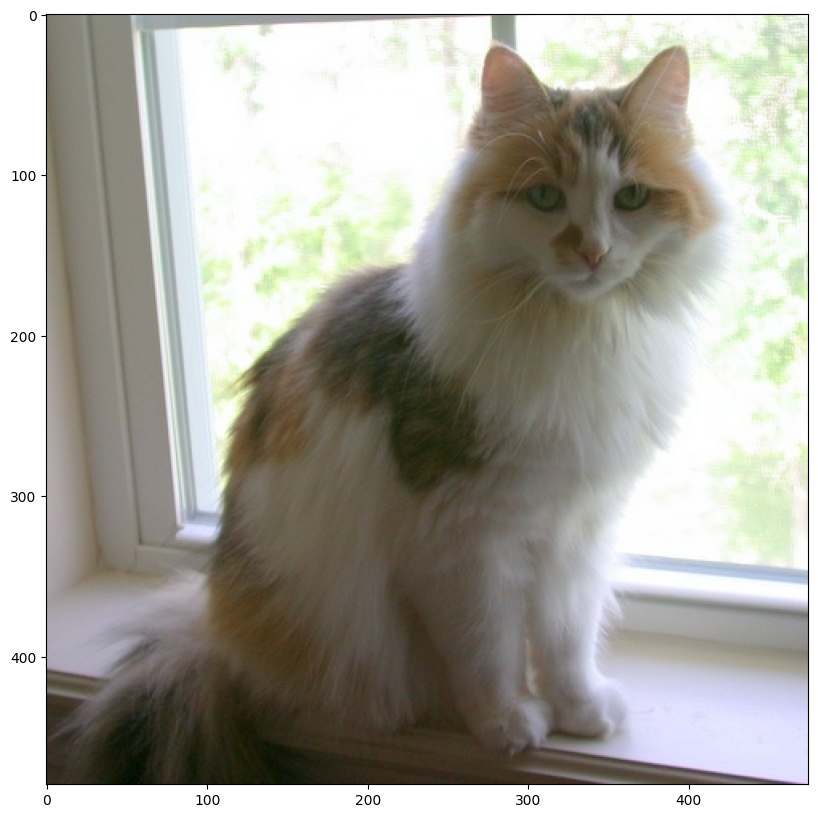

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
image = cv2.imread('data/test1.jpg')
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values,
and swap the color channels for input to SSD300.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


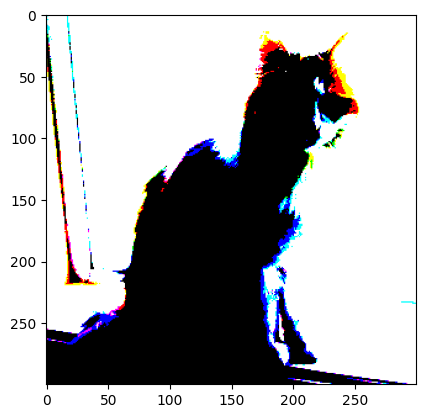

In [4]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [5]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
# net.phase = 'test'
y = net(xx) #, test=True
# y = traced_script_module(xx)
y

(tensor([[[[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]],
 
          [[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]],
 
          [[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]],
 
          [[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           ...,


## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold
Here we choose 60%

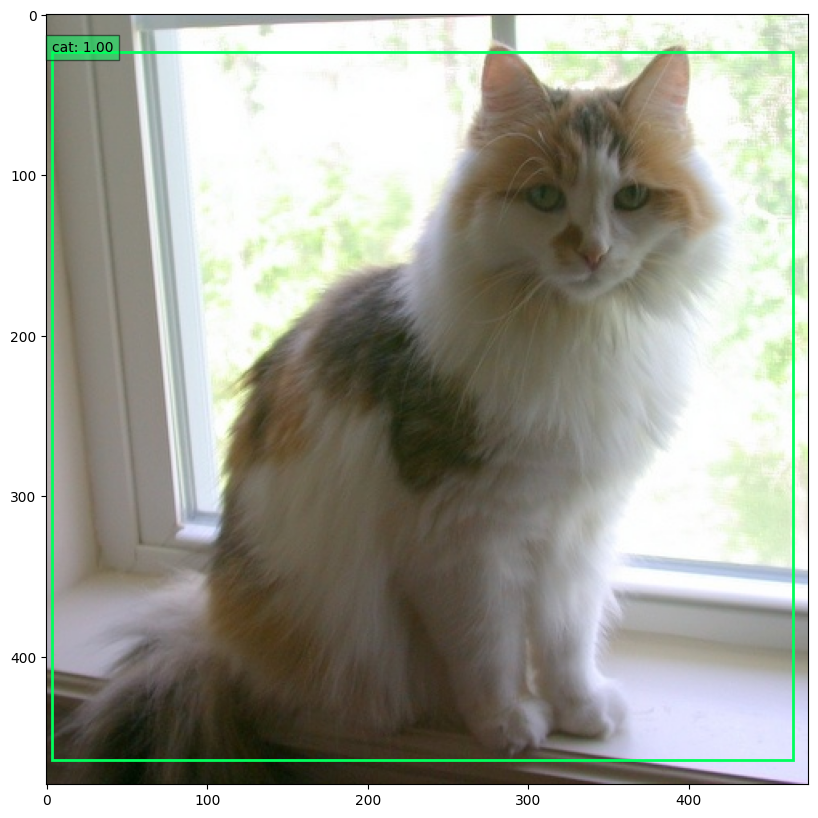

In [7]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y[0]
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

1 21 200 5
8000
-
tensor(0.9981)
8001
-
tensor(0.0062)
8002
-
tensor(0.0477)
8003
-
tensor(0.9767)
8004
-
tensor(0.9650)
8005
-
tensor(0.0105)
8006
-
tensor(-0.0118)
8007
-
tensor(0.4632)
8008
-
tensor(0.6191)
8009
-
tensor(1.0017)
torch.Size([21000])
(475, 480)
tensor([475., 480., 475., 480.])


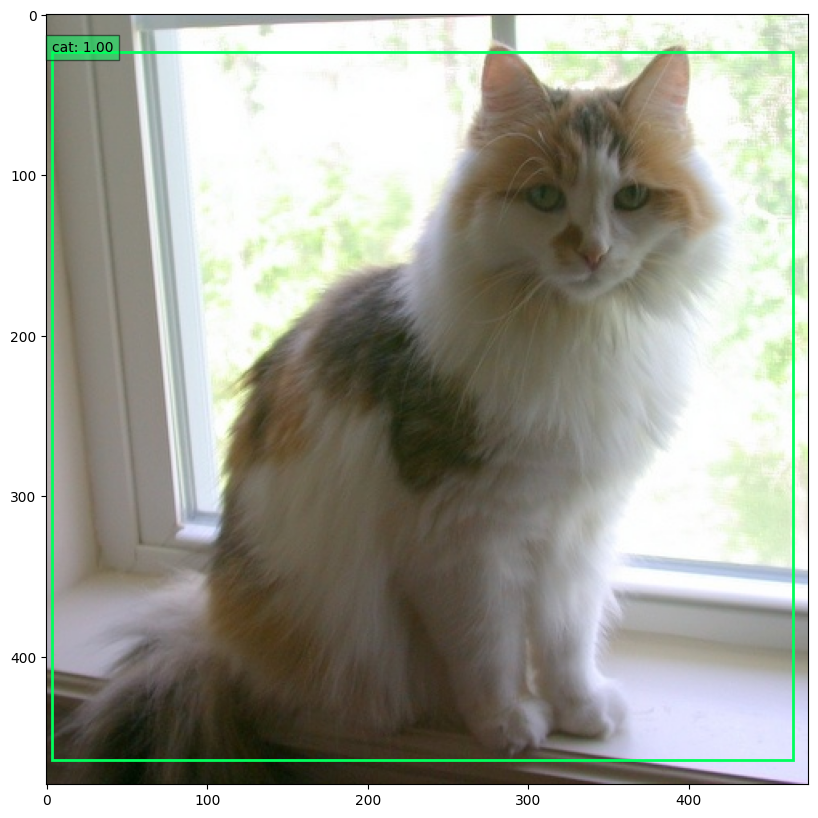

In [6]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
a = y[0].size(0)
b = y[0].size(1)
c = y[0].size(2)
d = y[0].size(3)
print(a, b, c, d)
detections = y[0].flatten()
for i in range(0, 21000):
    if detections[i] != 0.0:
        print(i)
        print("-")
        print(detections[i])
print(detections.shape)
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
print(rgb_image.shape[1::-1])
print(scale)
for i in range(b):
    j = 0
    while detections[i*c*d+j*d] >= 0.6:
        score = detections[i*c*d+j*d]
        label_name = labels[i]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[(i*c*d+j*d+1):(i*c*d+j*d+5)]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

In [32]:
a = torch.Tensor([1,2,3]).repeat(2)
a

tensor([1., 2., 3., 1., 2., 3.])